<font size=4>This project aims to analyze the Manchester housing market by integrating diverse data sources: social housing asset data, brownfield development registers, and the Index of Multiple Deprivation (IMD). The core objectives are to reveal the spatial distribution of housing assets, assess the strategic orientation of brownfield development, and identify potential risks.</font>

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
sns.set_style('whitegrid')

# Part 1: Manchester Social Housing Asset Data Analysis

In [95]:
file_housing = 'Manchester_Social_Housing_Asset_Value_2025.xlsx' # Housing asset value data, data source:https://www.data.gov.uk/dataset/60f0bc7c-9a5d-44dc-937a-5ba0c4b66a7f/social-housing-asset-value-manchester
try:
    df_housing = pd.read_excel(file_housing)
    print(f'Successfully loaded, original row count: {len(df_housing)}')
    print(df_housing.head())
except FileNotFoundError:
    print('File not found')
    df_housing = pd.DataFrame()

Successfully loaded, original row count: 69
  SectorMerged    Valuation Band  Intervening Band  Total Dwellings  \
0         M1 7  < 50000 to 99999            <50000              114   
1         M1 7  < 50000 to 99999    70000 to 89999               10   
2         M1 7  < 50000 to 99999    90000 to 99999               26   
3         M1 7  100000 to 299999  100000 to 119999               13   
4         M1 7  100000 to 299999  120000 to 139999               13   

   EUVSH Total  EUVSH Average  Market Total  Market Average  Percent Occupied  \
0      5373000    47131.57895      13432500     117828.9474          0.991228   
1       790000    79000.00000       1975000     197500.0000          1.000000   
2      2427000    93346.15385       6067500     233365.3846          1.000000   
3      1378000   106000.00000       3445000     265000.0000          1.000000   
4      1634000   125692.30770       4085000     314230.7692          1.000000   

   Percent Vacant  
0        0.008772  
1 

In [96]:
def clean_sector(sector_raw):
    # Standardise the sector data into a single format, using the first part to represent the sector
    if pd.isna(sector_raw):
        return None

    s = str(sector_raw).strip()

    if '/' in s:
        return s.split('/')[0].strip()
    if ',' in s or 'and' in s:
        parts = s.split(' ')
        return f'{parts[0]} {parts[1].replace(",", "").strip()}'
    return s

df_housing['Postcode_Sector'] = df_housing['SectorMerged'].apply(clean_sector)

''' Upon inspection, it was discovered that the raw data splits the same sector into multiple rows based on the 'Valuation Band' and 'Intervening Band'. Consequently, sector-level totals cannot be analysed directly using the raw rows; a 'GroupBy' operation is required first
'''

df_housing_agg = df_housing.groupby('Postcode_Sector').agg({
    'Total Dwellings': 'sum',
    'EUVSH Total': 'sum',
    'Market Total': 'sum',
    'Percent Vacant': 'mean'
}).reset_index()

# Recalculate features based on the aggregated data

df_housing_agg['EUVSH_Avg'] = df_housing_agg['EUVSH Total'] / df_housing_agg['Total Dwellings']
df_housing_agg['Market_Avg'] = df_housing_agg['Market Total'] / df_housing_agg['Total Dwellings']

df_housing_agg['Value_Gap'] = df_housing_agg['Market_Avg'] - df_housing_agg['EUVSH_Avg']

df_housing_agg['Total_Value_Locked'] = df_housing_agg['Market Total'] - df_housing_agg['EUVSH Total']

df_housing_agg['Discount_Ratio'] = df_housing_agg['EUVSH_Avg'] / df_housing_agg['Market_Avg']

print(df_housing_agg.sort_values('Total_Value_Locked', ascending=False))

   Postcode_Sector  Total Dwellings  EUVSH Total  Market Total  \
15            M9 5             2386    127919872     319799680   
10           M40 7             1415     91860200     229650500   
3            M13 9              963     78472200     196180500   
8            M40 2             1400     75094400     187736000   
7            M40 0             1274     70224400     175561000   
14            M9 0             1365     65080400     162701000   
11           M40 8             1170     57204600     143011500   
16            M9 7             1302     52422800     131057000   
9            M40 3              895     50772600     126931500   
17            M9 8              684     34950400      87376000   
13            M8 6              616     27470200      68675500   
12            M8 0              508     23155200      57888000   
5             M4 5              313     18406400      46016000   
1            M12 5              170     12511200      31278000   
0         

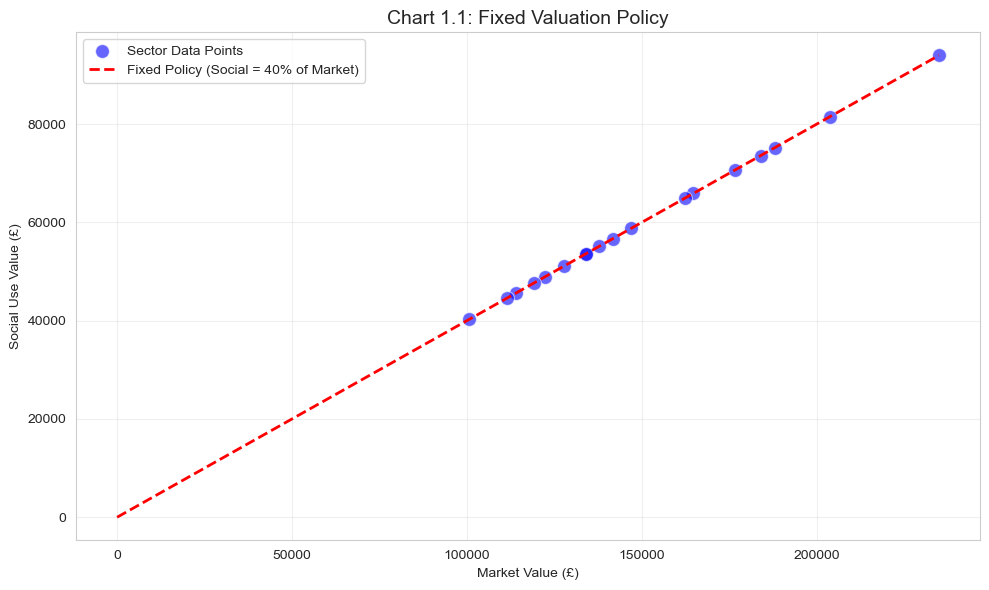

In [97]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_housing_agg,
    x='Market_Avg',
    y='EUVSH_Avg',
    color='blue',
    s=100,
    alpha=0.6,
    label='Sector Data Points'
)
x_range = np.linspace(0, df_housing_agg['Market_Avg'].max(), 100)
y_fixed = x_range * 0.4
plt.plot(x_range, y_fixed, 'r--', linewidth=2, label='Fixed Policy (Social = 40% of Market)')

plt.title('Chart 1.1: Fixed Valuation Policy', fontsize=14)
plt.xlabel('Market Value (£)')
plt.ylabel('Social Use Value (£)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 1.1 demonstrates a perfect linear relationship between market value and social value, with all data points aligning precisely along the trend line $y = 0.4x$. This indicates that the social valuations in this dataset are not derived from independent assessments of individual properties, but strictly adhere to government accounting policy, applying a uniform 40% adjustment factor to market values.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'M9 5'),
  Text(1, 0, 'M40 7'),
  Text(2, 0, 'M13 9'),
  Text(3, 0, 'M40 2'),
  Text(4, 0, 'M40 0'),
  Text(5, 0, 'M9 0'),
  Text(6, 0, 'M40 8'),
  Text(7, 0, 'M9 7'),
  Text(8, 0, 'M40 3'),
  Text(9, 0, 'M9 8')])

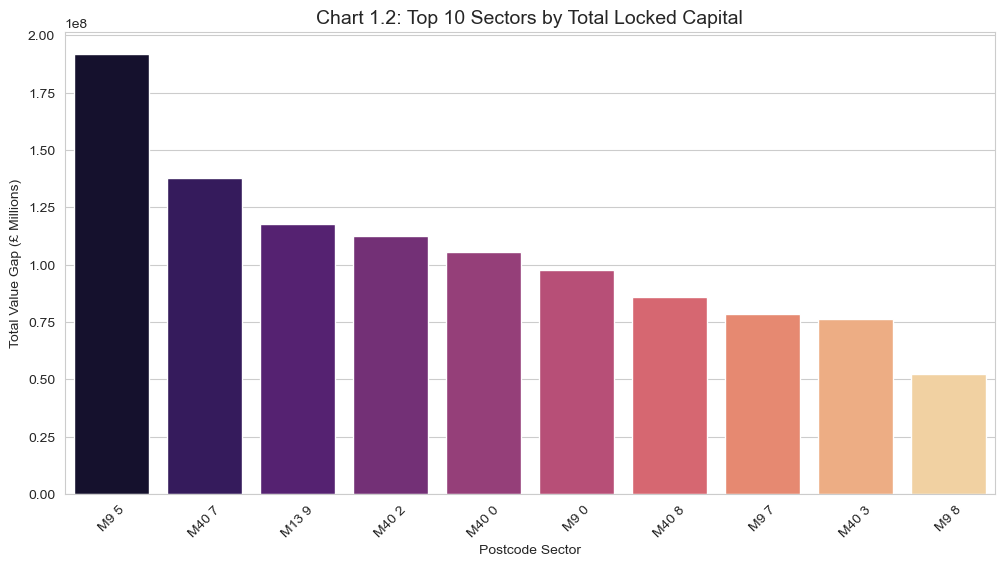

In [98]:
plt.figure(figsize=(12, 6))

top_10 = df_housing_agg.sort_values('Total_Value_Locked', ascending=False).head(10)
sns.barplot(
    data=top_10,
    x='Postcode_Sector',
    y='Total_Value_Locked',
    hue='Postcode_Sector',
    palette='magma'
)

plt.title('Chart 1.2: Top 10 Sectors by Total Locked Capital', fontsize=14)
plt.ylabel('Total Value Gap (£ Millions)')
plt.xlabel('Postcode Sector')
plt.xticks(rotation=45)

Figure 2.2 illustrates the distribution profile of Manchester's social housing assets. Whilst city center properties command higher unit values, suburban neighborhoods such as M9 5 and M40 7 represent the true value core of the portfolio. Underpinned by their significant housing stock, these areas have accumulated over £100 million in Total Locked Capital.

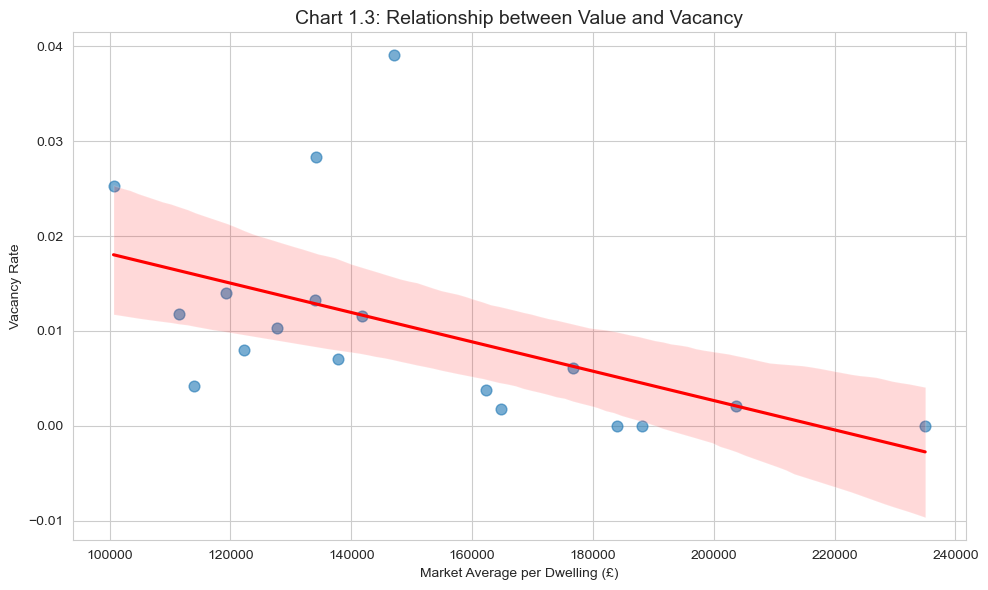

In [99]:
plt.figure(figsize=(10, 6))

sns.regplot(
    data=df_housing_agg,
    x='Market_Avg',
    y='Percent Vacant',
    scatter_kws={'alpha': 0.6, 's': 60},
    line_kws={'color': 'red'}
)

plt.title('Chart 1.3: Relationship between Value and Vacancy', fontsize=14)
plt.xlabel('Market Average per Dwelling (£)')
plt.ylabel('Vacancy Rate')
plt.tight_layout()
plt.show()

The regression analysis in Figure 1.3 demonstrates that higher market values are generally associated with lower vacancy rates, aligning with standard market dynamics. However, specific low-market-value areas exhibit anomalously high vacancy rates. This points to potential structural issues within certain deprived communities, suggesting that low demand is not solely driven by price factors. Consequently, these areas may require alternative intervention strategies.

# Part 2: Manchester Brownfield Data Analysis

In [100]:
file_brown = 'Manchesterbrownfield_sites2025.csv' # Manchester brownfield data, data source:https://www.data.gov.uk/dataset/b35f899a-f7be-4ff8-a0eb-a508653d0b5f/https-open-data-mcr-council-hub-arcgis-com-datasets-8d18c2a4effd442e820087a9ec064544_0-about
try:
    df_brown = pd.read_csv(file_brown)
    print(f'Successfully loaded, original row count: {len(df_brown)}')
    print(df_brown.head())
except FileNotFoundError:
    print('File not found')
    df_brown = pd.DataFrame()

Successfully loaded, original row count: 268
                                     OrganisationURI    SiteReference  \
0                                                NaN              NaN   
1  http://opendatacommunities.org/id/metropolitan...  140790/NMC/2024   
2  http://opendatacommunities.org/id/metropolitan...   128698/FO/2020   
3  http://opendatacommunities.org/id/metropolitan...   140735/FO/2024   
4  http://opendatacommunities.org/id/metropolitan...   132832/FO/2022   

                                     SiteNameAddress  \
0                                                NaN   
1                                     Arundel Street   
2  Vacant Land Bounded By Stockport Road, Swallow...   
3                          137 Oxford Road (STUDENT)   
4                 Upper floors, 5 - 7 Wilbraham Road   

                                         SiteplanURL       GeoY      GeoX  \
0                                                NaN        NaN       NaN   
1  https://experience.arc

In [101]:
initial_count = len(df_brown)
# data clean
df_brown = df_brown.dropna(subset=['GeoX', 'GeoY'])
df_brown = df_brown.dropna(subset=['NetDwellingsRangeFrom'])
df_brown = df_brown.dropna(subset=['Hectares'])

# Ensure that coordinates and numerical values are numeric types, not strings
df_brown['GeoX'] = pd.to_numeric(df_brown['GeoX'], errors='coerce')
df_brown['GeoY'] = pd.to_numeric(df_brown['GeoY'], errors='coerce')
df_brown['NetDwellingsRangeFrom'] = pd.to_numeric(df_brown['NetDwellingsRangeFrom'], errors='coerce')
print(len(df_brown))
print(df_brown[['SiteNameAddress', 'GeoX', 'GeoY', 'NetDwellingsRangeFrom', 'PlanningStatus']].head())

267
                                     SiteNameAddress      GeoX       GeoY  \
1                                     Arundel Street -2.260186  53.472723   
2  Vacant Land Bounded By Stockport Road, Swallow... -2.192919  53.449561   
3                          137 Oxford Road (STUDENT) -2.236911  53.470416   
4                 Upper floors, 5 - 7 Wilbraham Road -2.219548  53.442450   
5                  Abbey Hey Clinic Constable Street -2.165205  53.466816   

   NetDwellingsRangeFrom       PlanningStatus  
1                  366.0  Planning Permission  
2                   39.0  Planning Permission  
3                   20.0  Planning Permission  
4                    7.0  Planning Permission  
5                    6.0  Planning Permission  


In [102]:
# Development Density: indicates the number of planned dwellings per hectare
df_brown['Density'] = df_brown['NetDwellingsRangeFrom'] / df_brown['Hectares'].replace(0, np.nan) # Handle division by zero cases
print(df_brown['PlanningStatus'].value_counts()) # The PlanningStatus column comprises only two distinct values; therefore, it can be used directly without further cleaning.

# Project scale classification
def classify_scale(dwellings):
    if dwellings < 10: return 'Small (<10)'
    if dwellings <= 100: return 'Medium (10-100)'
    return 'Mega (>100)'
df_brown['Project_Scale'] = df_brown['NetDwellingsRangeFrom'].apply(classify_scale)

print(df_brown.head())

PlanningStatus
non-permissioned       196
Planning Permission     71
Name: count, dtype: int64
                                     OrganisationURI    SiteReference  \
1  http://opendatacommunities.org/id/metropolitan...  140790/NMC/2024   
2  http://opendatacommunities.org/id/metropolitan...   128698/FO/2020   
3  http://opendatacommunities.org/id/metropolitan...   140735/FO/2024   
4  http://opendatacommunities.org/id/metropolitan...   132832/FO/2022   
5  http://opendatacommunities.org/id/metropolitan...   139693/FO/2024   

                                     SiteNameAddress  \
1                                     Arundel Street   
2  Vacant Land Bounded By Stockport Road, Swallow...   
3                          137 Oxford Road (STUDENT)   
4                 Upper floors, 5 - 7 Wilbraham Road   
5                  Abbey Hey Clinic Constable Street   

                                         SiteplanURL       GeoY      GeoX  \
1  https://experience.arcgis.com/experience/a04a4...

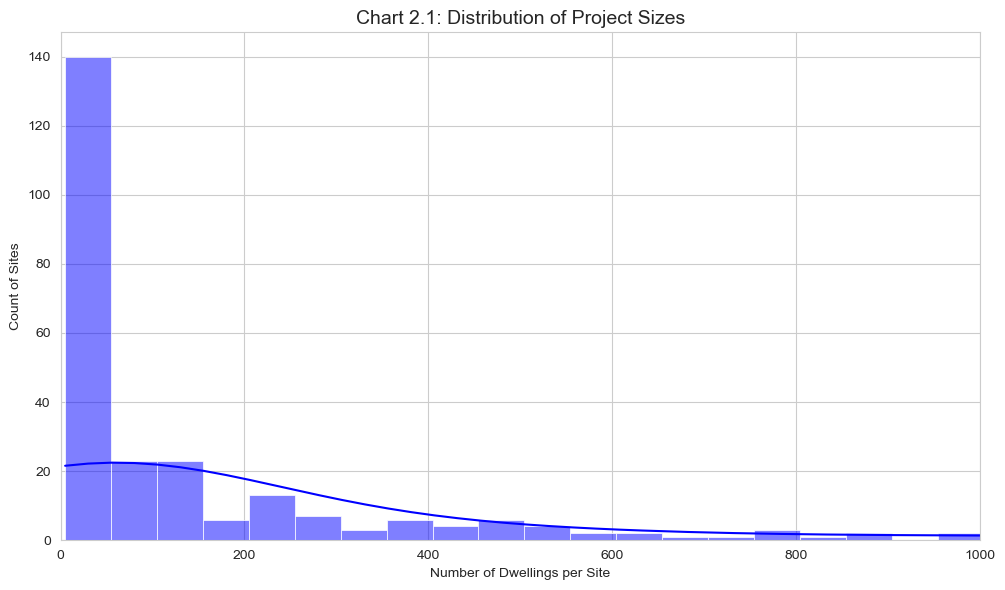

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_brown['NetDwellingsRangeFrom'],
    bins=100,
    kde=True,
    color='blue'
)
plt.title('Chart 2.1: Distribution of Project Sizes', fontsize=14)
plt.xlabel('Number of Dwellings per Site')
plt.ylabel('Count of Sites')
plt.tight_layout()
plt.xlim(0, 1000)
plt.show()

Figure 2.1 illustrates that the housing supply for the majority of brownfield projects is concentrated on the 0–50 unit range.

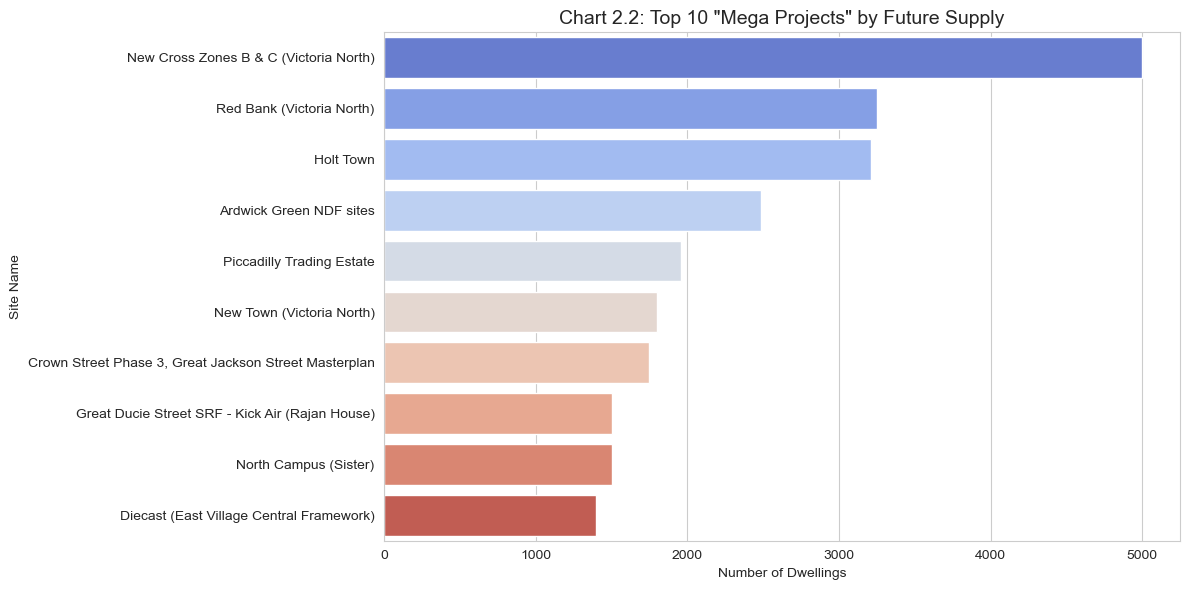

In [104]:
top_10_sites = df_brown.sort_values('NetDwellingsRangeFrom', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10_sites,
    y='SiteNameAddress',
    x='NetDwellingsRangeFrom',
    palette='coolwarm',
    hue='SiteNameAddress',
    legend=False
)

plt.title('Chart 2.2: Top 10 "Mega Projects" by Future Supply', fontsize=14)
plt.xlabel('Number of Dwellings')
plt.ylabel('Site Name')

plt.tight_layout()
plt.show()

Figure 2.2 illustrates the top 10 largest-scale projects in the future pipeline.

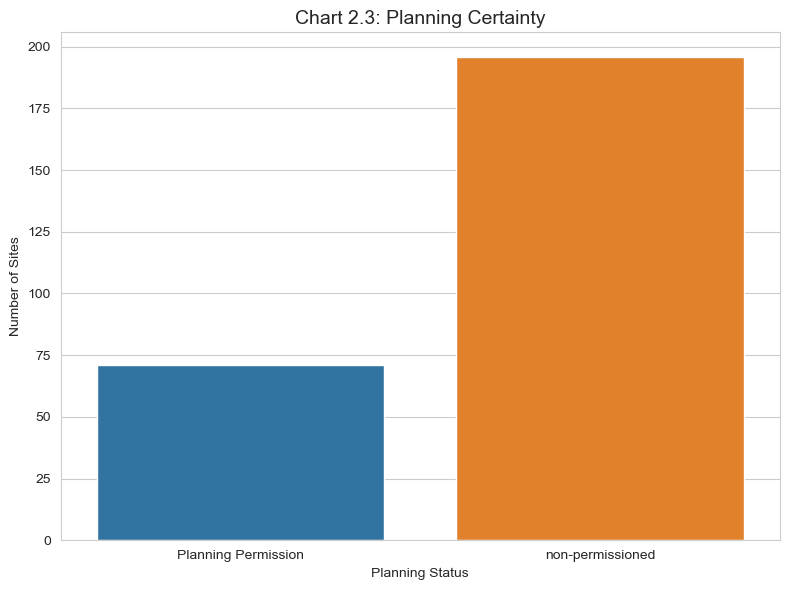

In [105]:
plt.figure(figsize=(8, 6))

sns.countplot(
    data=df_brown,
    x='PlanningStatus',
    hue='PlanningStatus',
)

plt.title('Chart 2.3: Planning Certainty', fontsize=14)
plt.xlabel('Planning Status')
plt.ylabel('Number of Sites')

plt.tight_layout()
plt.show()

Figure 2.3 compares the volume of permissioned versus non-permissioned projects. The chart reveals that non-permissioned projects outnumber approved ones by a factor of two to three, indicating that a significant portion of the supply on the brownfield register remains in the planning pipeline. This presents a significant uncertainty risk for future housing delivery; should planning policies tighten or developers withdraw investment, this potential supply could be drastically reduced or disappear entirely.

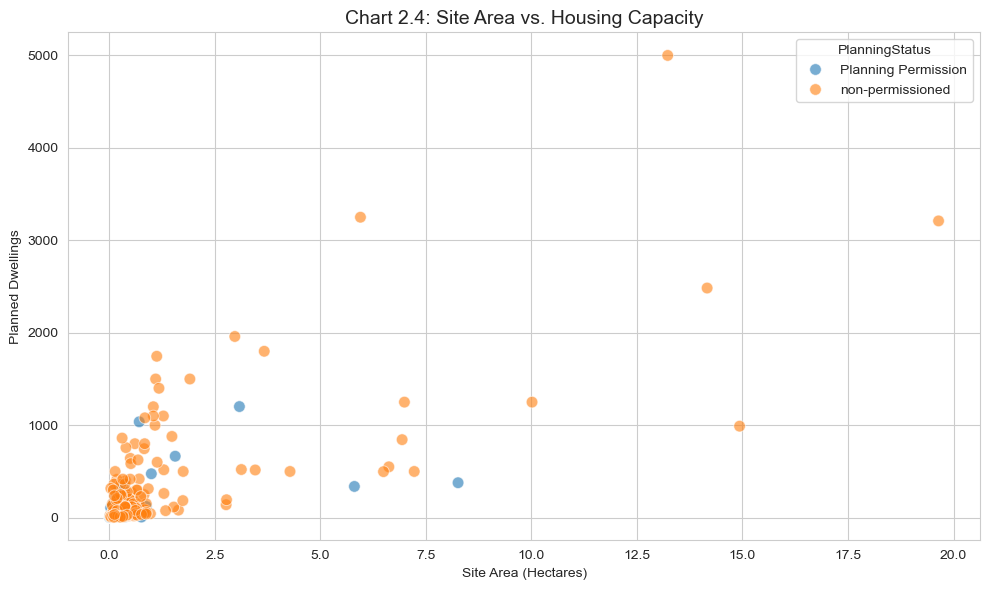

In [106]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_brown,
    x='Hectares',
    y='NetDwellingsRangeFrom',
    alpha=0.6,
    hue='PlanningStatus',
    s=70
)
plt.title('Chart 2.4: Site Area vs. Housing Capacity', fontsize=14)
plt.xlabel('Site Area (Hectares)')
plt.ylabel('Planned Dwellings')
plt.tight_layout()
plt.show()

Figure 2.4 reveals that the scatter points are predominantly clustered in the bottom-left corner, indicating that the majority of projects are small-scale developments characterized by a limited footprint and low dwelling count. In contrast, the areas in the top-right and bottom-right quadrants are non-permissioned projects, suggesting a slower approval process for large villa estates and extensive residential complexes.

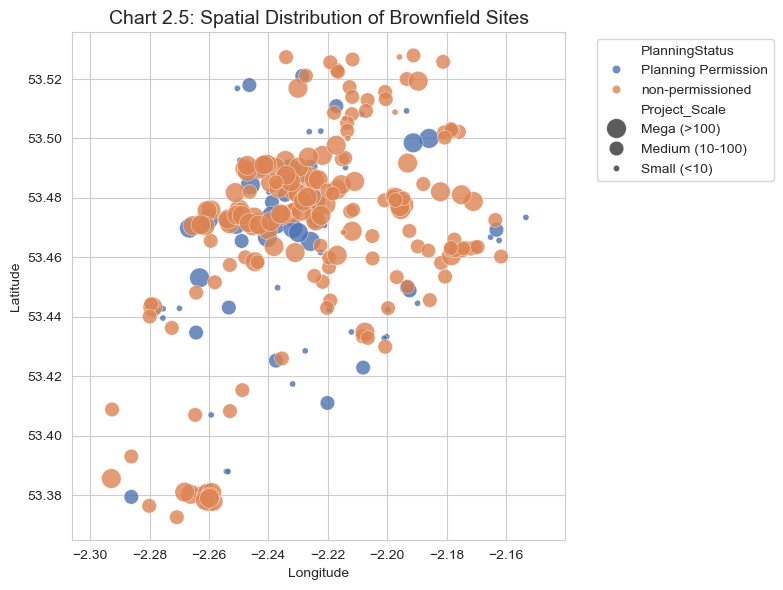

In [107]:
scale_order = ['Mega (>100)', 'Medium (10-100)', 'Small (<10)']
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_brown,
    x='GeoX',
    y='GeoY',
    hue='PlanningStatus',
    size='Project_Scale',
    sizes=(20, 200),
    size_order=scale_order,
    palette='deep',
    alpha=0.8
)
plt.title('Chart 2.5: Spatial Distribution of Brownfield Sites', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()

Figure 2.5 reflects the spatial characteristics of project distribution. A dense cluster of large-scale projects is evident in the central area, the majority of which have already been granted planning permission, confirming the city center as a focal point for high-density development. In contrast, the periphery is scattered with many small-scale projects displaying mixed colors, indicating that suburban development is more fragmented and subject to varying planning outcomes.

# Part 3: Overall Analysis
Given the discrepancies in geographical formatting between the previously analyzed datasets, the Postcode Directory was introduced to standardize location attributes, whilst Index of Multiple Deprivation (IMD) data was integrated to enrich the analysis. It is pertinent to note that these supplementary datasets were sourced independently, rather than via the https://www.data.gov.uk/ portal.
By establishing a master index, we linked the Manchester Social Housing Asset Data, the Brownfield Land Register, and the IMD records, thereby generating a final consolidated dataset for comprehensive analysis.

In [108]:
file_lookup = 'ONSPD_FEB_2025_UK_M.csv' # ONS Postcode Directory (February 2025) for the UK，data source: https://geoportal.statistics.gov.uk/datasets/6fb8941d58e54d949f521c92dfb92f2a/about
file_imd = 'File_1_IoD2025_Index_of_Multiple_Deprivation.xlsx' # English indices of deprivation 2025, data source: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2025

try:
    df_lookup = pd.read_csv(file_lookup, usecols=['pcds', 'lat', 'long', 'lsoa21'])
    print(f'Successfully loaded, original row count: {len(df_lookup)}')
except FileNotFoundError:
    print(f'File not found')
    df_lookup = pd.DataFrame()

Successfully loaded, original row count: 59898


In [109]:
df_lookup['Postcode_Sector'] = df_lookup['pcds'].str[:-2].str.strip() # Extract Postcode Sector
# Calculate the mean latitude and longitude of all postcodes within the sector to determine its centroid.
sector_locs = df_lookup.groupby('Postcode_Sector')[['lat', 'long']].mean().reset_index()
print(sector_locs.head())

  Postcode_Sector        lat      long
0            M1 1  53.482353 -2.235632
1            M1 2  53.479268 -2.229434
2            M1 3  53.477521 -2.236114
3            M1 4  53.478278 -2.240318
4            M1 5  53.474526 -2.244140


In [110]:
try:
    # The original Excel workbook comprises two worksheets; the initial 'Notes' sheet is skipped to access the content of the second sheet exclusively.
    xls = pd.ExcelFile(file_imd)
    target_sheet = xls.sheet_names[1]
    df_imd = pd.read_excel(file_imd, sheet_name=target_sheet)
    print(f'Successfully loaded, original row count: {len(df_imd)}')

    imd_cols = {
        col: 'IMD_Decile' for col in df_imd.columns if 'Decile' in col and 'IMD' in col
    }
    imd_cols.update({col: 'lsoa21' for col in df_imd.columns if 'LSOA code' in col})
    df_imd = df_imd.rename(columns=imd_cols)[['lsoa21', 'IMD_Decile']]
except FileNotFoundError:
    print(f'File not found')
    df_imd = pd.DataFrame()
print(df_imd.head())

Successfully loaded, original row count: 33755
      lsoa21  IMD_Decile
0  E01000001           8
1  E01000002          10
2  E01000003           8
3  E01000005           5
4  E01000006           4


In [111]:
df_lookup_imd = pd.merge(df_lookup, df_imd, on='lsoa21', how='left')
# As a single Postcode Sector may comprise multiple LSOAs, the mean deprivation score for each sector is calculated.
sector_imd = df_lookup_imd.groupby('Postcode_Sector')['IMD_Decile'].mean().reset_index()
print(sector_imd.head())

  Postcode_Sector  IMD_Decile
0            M1 1    4.473684
1            M1 2    5.228571
2            M1 3    4.521212
3            M1 4    4.298507
4            M1 5    5.443662


In [112]:
# Construct the final Bridge Table.
# Include: Sector, Lat, Long, IMD_Decile
sector_lookup = pd.merge(sector_locs, sector_imd, on='Postcode_Sector', how='inner')
print(sector_lookup.head())

  Postcode_Sector        lat      long  IMD_Decile
0            M1 1  53.482353 -2.235632    4.473684
1            M1 2  53.479268 -2.229434    5.228571
2            M1 3  53.477521 -2.236114    4.521212
3            M1 4  53.478278 -2.240318    4.298507
4            M1 5  53.474526 -2.244140    5.443662


In [113]:
# Identify the nearest postcode sector centroid for each brownfield project to determine its sector assignment.
def get_nearest_sector(site_row, sectors_df):
    # Calculate the Euclidean distance between the project location (GeoX, GeoY) and the centroids of all sectors (long, lat).
    distances = (sectors_df['lat'] - site_row['GeoY'])**2 + \
                (sectors_df['long'] - site_row['GeoX'])**2
    return sectors_df.iloc[distances.argmin()]['Postcode_Sector']
# Identify the nearest sector, and populate a new column with the sector name.
df_brown['Postcode_Sector'] = df_brown.apply(
        lambda row: get_nearest_sector(row, sector_lookup), axis=1
    )

In [114]:
brownfield_sector = df_brown.groupby('Postcode_Sector').agg({
        'NetDwellingsRangeFrom': 'sum',
        'SiteNameAddress': 'count',
        'Hectares': 'sum'
    }).reset_index()


brownfield_sector.columns = ['Postcode_Sector', 'Dwelling_Count', 'Project_Count', 'Total_Site_Area']
print(len(brownfield_sector))
print(brownfield_sector.head())

87
  Postcode_Sector  Dwelling_Count  Project_Count  Total_Site_Area
0            M1 2          2503.0              9         2.597854
1            M1 4            14.0              1         0.032051
2            M1 5          2846.0              7         2.936487
3            M1 6           107.0              1         0.033730
4            M1 7          3443.0              7         4.759652


In [115]:
# Merge housing asset data and deprivation indices
df_housing_IMD = pd.merge(df_housing_agg, sector_lookup[['Postcode_Sector', 'IMD_Decile']],
                   on='Postcode_Sector', how='left')
print(df_housing_IMD.head())

  Postcode_Sector  Total Dwellings  EUVSH Total  Market Total  Percent Vacant  \
0            M1 7              176     11602000      29005000        0.001754   
1           M12 5              170     12511200      31278000        0.000000   
2           M13 0               18      1692000       4230000        0.000000   
3           M13 9              963     78472200     196180500        0.002075   
4            M4 1               42      3160000       7900000        0.000000   

      EUVSH_Avg     Market_Avg      Value_Gap  Total_Value_Locked  \
0  65920.454545  164801.136364   98880.681818            17403000   
1  73595.294118  183988.235294  110392.941176            18766800   
2  94000.000000  235000.000000  141000.000000             2538000   
3  81487.227414  203718.068536  122230.841121           117708300   
4  75238.095238  188095.238095  112857.142857             4740000   

   Discount_Ratio  IMD_Decile  
0             0.4    4.276190  
1             0.4    1.002941  
2 

In [116]:
# Merge brownfield data
# Certain areas may lack brownfield projects; therefore, a Left Join is applied.
df_final = pd.merge(df_housing_IMD, brownfield_sector, on='Postcode_Sector', how='left')
print(df_final.head())

  Postcode_Sector  Total Dwellings  EUVSH Total  Market Total  Percent Vacant  \
0            M1 7              176     11602000      29005000        0.001754   
1           M12 5              170     12511200      31278000        0.000000   
2           M13 0               18      1692000       4230000        0.000000   
3           M13 9              963     78472200     196180500        0.002075   
4            M4 1               42      3160000       7900000        0.000000   

      EUVSH_Avg     Market_Avg      Value_Gap  Total_Value_Locked  \
0  65920.454545  164801.136364   98880.681818            17403000   
1  73595.294118  183988.235294  110392.941176            18766800   
2  94000.000000  235000.000000  141000.000000             2538000   
3  81487.227414  203718.068536  122230.841121           117708300   
4  75238.095238  188095.238095  112857.142857             4740000   

   Discount_Ratio  IMD_Decile  Dwelling_Count  Project_Count  Total_Site_Area  
0             0.4 

In [117]:
# Missing values are populated with 0
df_final['Dwelling_Count'] = df_final['Dwelling_Count'].fillna(0)
df_final['Project_Count'] = df_final['Project_Count'].fillna(0)
df_final['Total_Site_Area'] = df_final['Total_Site_Area'].fillna(0)
print(df_final.head())

  Postcode_Sector  Total Dwellings  EUVSH Total  Market Total  Percent Vacant  \
0            M1 7              176     11602000      29005000        0.001754   
1           M12 5              170     12511200      31278000        0.000000   
2           M13 0               18      1692000       4230000        0.000000   
3           M13 9              963     78472200     196180500        0.002075   
4            M4 1               42      3160000       7900000        0.000000   

      EUVSH_Avg     Market_Avg      Value_Gap  Total_Value_Locked  \
0  65920.454545  164801.136364   98880.681818            17403000   
1  73595.294118  183988.235294  110392.941176            18766800   
2  94000.000000  235000.000000  141000.000000             2538000   
3  81487.227414  203718.068536  122230.841121           117708300   
4  75238.095238  188095.238095  112857.142857             4740000   

   Discount_Ratio  IMD_Decile  Dwelling_Count  Project_Count  Total_Site_Area  
0             0.4 

In [118]:
df_final.to_csv('final_data.csv', index=False)

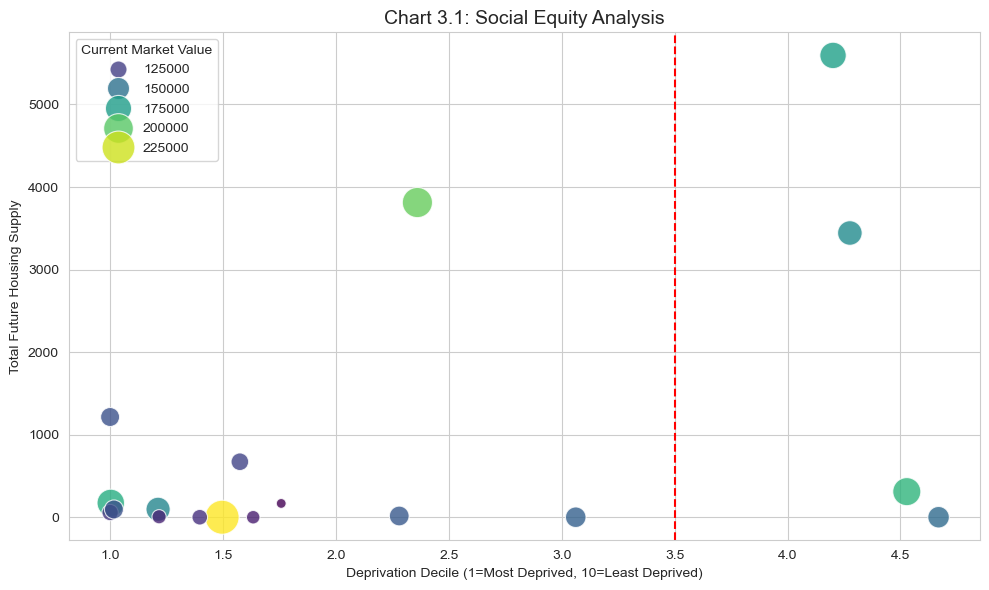

In [119]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_final,
    x='IMD_Decile',
    y='Dwelling_Count',
    size='Market_Avg',
    sizes=(50, 600),
    hue='Market_Avg',
    palette='viridis',
    alpha=0.8
)
plt.title('Chart 3.1: Social Equity Analysis', fontsize=14)
plt.xlabel('Deprivation Decile (1=Most Deprived, 10=Least Deprived)')
plt.ylabel('Total Future Housing Supply')
plt.legend(title='Current Market Value')
plt.axvline(x=3.5, color='red', linestyle='--', label='High Deprivation Zone')
plt.tight_layout()
plt.show()

Figure 3.1 illustrates the relationship between deprivation levels and projected housing supply, with bubble size and color representing the current average market value of each area. The analysis reveals that deprived neighborhoods generally attract lower volumes of new development and exhibit lower market values, suggesting that market forces continue to prioritize high-value areas. However, certain deprived areas are experiencing high levels of development activity; in these instances, the risk of gentrification requires careful mitigation.

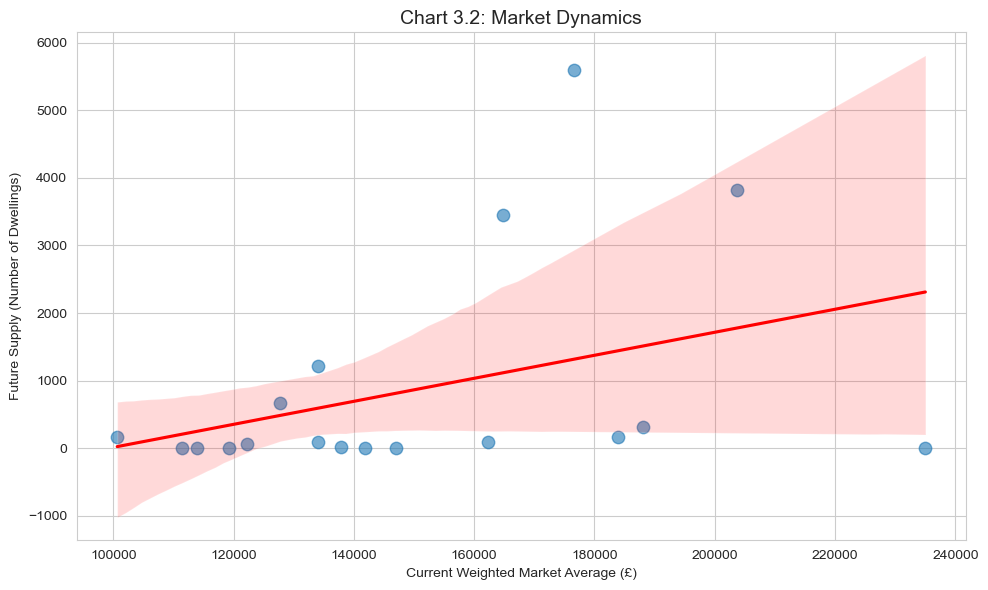

In [120]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_final,
    x='Market_Avg',
    y='Dwelling_Count',
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color':'red'}
)
plt.title('Chart 3.2: Market Dynamics', fontsize=14)
plt.xlabel('Current Weighted Market Average (£)')
plt.ylabel('Future Supply (Number of Dwellings)')
plt.tight_layout()
plt.show()

Figure 3.2 illustrates the relationship between current average market values and projected housing supply, where the red line represents the trend. The data indicates that areas commanding higher current property prices are set to receive larger volumes of future supply, suggesting that market forces are gravitating towards proven high-value locations.

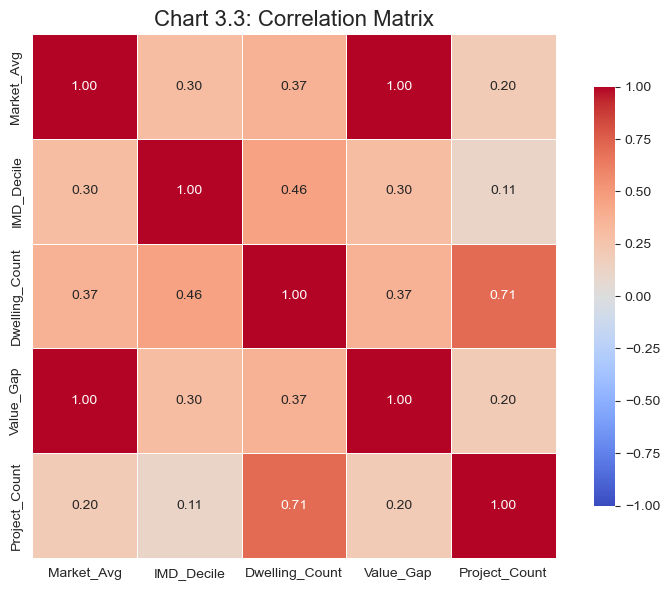

In [121]:
corr_matrix = df_final[['Market_Avg', 'IMD_Decile', 'Dwelling_Count', 'Value_Gap', 'Project_Count']].corr()
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Chart 3.3: Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

The correlation matrix reveals a coefficient of 0.37 between `Dwelling_Count` and `Market_Avg`, and 0.46 between `Dwelling_Count` and `IMD_Decile`. This corroborates the analysis in Figures 3.1 and 3.2, confirming that development volume exhibits a moderate positive correlation with house prices, and an even stronger positive correlation with the area's level of affluence.

# Conclusion

This project has integrated social housing asset records, brownfield development data, and deprivation indices to reveal spatial misalignment in the Manchester housing market between value distribution and future supply potential. The analysis indicates that whilst city center properties command exceptionally high unit values, the true size of asset value and large-scale development potential is concentrated in more deprived areas, notably in the North and East. This "Brownfield First" strategy, which directs development towards lower-value zones, undoubtedly catalyzes urban regeneration; however, it concurrently introduces risks of inflating local property prices and triggering gentrification. Consequently, future housing policy must strike a delicate balance between leveraging high-value assets for capital generation and safeguarding the interests of low-income communities, thereby ensuring that the dividends of urban development are shared more equitably across the resident population.